In [1]:

# Modeling antiproliferative activity values (pEC50) of potential Hsp70 allosteric modulators in MCF-7 cancer cell lines #


In [2]:
# Read in the experimental data
import pandas as pd
import numpy as np

df = pd.read_csv("./Hsp70_pEC50.csv")  

# Data obtained from published references at the end


,Compound,R1,R2,R3,pEC50,SMILES,ROMol
0,MKT-077,H,CC,CC,5.66,CCN1C(=O)C(=C2SC3=CC=CC=C3N2C)SC1=CC1=CC=CC=[N...,
1,YM-01,H,CC,C,5.28,CCN1C(=O)C(=C2SC3=CC=CC=C3N2C)SC1=CC1=CC=CC=[N...,
2,1,F,CC,C,5.66,CCN1C(=O)C(=C2SC3=CC=C(F)C=C3N2C)SC1=CC1=CC=CC...,
3,2,F,CC,C,4.74,CCN1C(=O)C(=C2SC3=CC=C(F)C=C3N2C)SC1=CC1=CC=CC...,
4,3,F,CC,C,5.21,CCN1C(=O)C(=C2SC3=CC=C(F)C=C3N2C)SC1=CC1=CC=CC...,

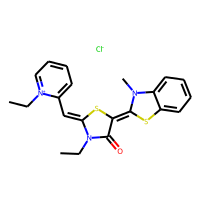
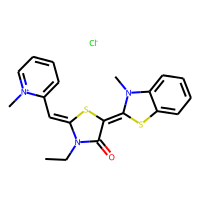
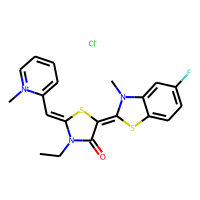
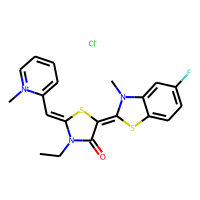
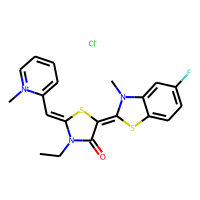

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import rdDepictor

# Visually inspect the data 

PandasTools.AddMoleculeColumnToFrame(df,smilesCol='SMILES')
df.head()

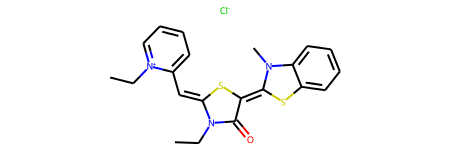

In [4]:

# Convert SMILES strings to a list of rdkit Mol objects

df['smi_Mols'] = [Chem.MolFromSmiles(x) for x in df['SMILES']]
df['smi_Mols'][0]

In [5]:

# Get features and labels of training and test sets

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors


In [6]:

# Use modred tool to obtain features

def Mordred_descriptors(smis):
    '''
    Calculates modred descriptors for a list of molecules
    '''
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(m) for m in smis]
    modred_df = calc.pandas(mols)
    return modred_df


In [7]:

# Calculate the properties (features) that are required to compute pEC50.

x_train_test_features = Mordred_descriptors(df['SMILES'])


100%|██████████| 48/48 [00:05<00:00,  9.43it/s]


In [8]:

# Obtain labels (pEC50)

y_train_test_labels = df['pEC50']


In [9]:
# ============                                ============ #
#              Stepwise regression elimination 
# ============                                ============ #

In [10]:

# First

# Get rid of redundant descriptors with low variance using stepwise regression


# Identify columns from modred descriptors containing numerical variables

typ = [x for x in [x_train_test_features.dtypes]] #obtain datatypes in each column

numericals = [] #Store column names of columns containing numerical datatypes in numericals list
strings = []    #Store column names of columns containing strings in stings list

count=0
for x in typ[0][:]:
    if x == 'float64' or x  == 'int64':
        numericals.append(typ[0].index[count])
    else:
        strings.append(typ[0].index[count])
    count+=1

len(numericals)

1185

In [11]:

# Next drop the redundant descriptors

# Null Hypothesis (0H): Coefficients having p-values of 0.05 or less are statistically significant
# i.e drop features with p-values greater than 0.05


In [12]:

import statsmodels.api as stm
import warnings
warnings.filterwarnings('ignore')


x_columns = numericals #feature names

y = df['pEC50'] # labels

# Function to calculate p-values per column

def get_stats(df_name, x_columns):    
    x = df_name[x_columns]
    results = stm.OLS(y, x).fit()
    return results.summary()



In [13]:
# Calculate stats 

### Round 1

round1  = get_stats(x_train_test_features, x_columns)

# View the stats summary
summary_text = ''.join(str(round1))

print(len(summary_text))

print(summary_text[0:5010])


# We are interested in P-values (P>|t|)

#Retain columns with P>|t| values of 0.05 or less


100260
                            OLS Regression Results                            
Dep. Variable:                  pEC50   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     13.03
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           1.24e-08
Time:                        16:35:51   Log-Likelihood:                 10.698
No. Observations:                  48   AIC:                             26.60
Df Residuals:                      24   BIC:                             71.51
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ABC             5.169e-07   1.03e-06 

In [14]:

# Function to eliminate features with pvals > 0.05

def elim(round_features):
    temp = []
    iter_df = round_features.loc[:,['Descriptor', 'pvals']]
    for a, b in iter_df.itertuples(index=False):
        #print(a, b)
        if float(b) > 0.05:
            temp.append(a)
    return temp


In [15]:

# Write out the summary, convert to a csv file with a header

#with open('round1.csv', 'w', encoding='UTF8') as f:
#    f.write(str(round1))

# Import the stats summary table

round1_stats = pd.read_csv("round1.csv", delim_whitespace=True)

round1_stats.head(5)


,Descriptor,coef,stderr,t,pvals,y,z
0,ABC,5.169000e-07,1.030000e-06,0.502,0.620,-1.610000e-06,2.640000e-06
1,ABCGG,-4.910000e-05,1.540000e-05,-3.178,0.004,-8.100000e-05,-1.720000e-05
2,nAcid,8.794000e-13,6.260000e-13,1.406,0.173,-4.120000e-13,2.170000e-12
3,nBase,-3.399000e-13,2.040000e-13,-1.664,0.109,-7.610000e-13,8.160000e-14
4,nAromAtom,1.317000e-08,3.750000e-09,3.511,0.002,5.430000e-09,2.090000e-08


In [16]:
seed = 55

# First remove rows containing nans
    
round1_stats_copy = round1_stats.dropna()

# eliminate columns with pvals > 0.05

round1_columns = elim(round1_stats_copy)

len(round1_columns)

# 745 out of 1185 numerical features are statisticaly significant


745

In [17]:

# Retrieve data associated to features that passed the 1st elimination round

round1_data = x_train_test_features[round1_columns]


In [18]:

### Round 2

round2 = get_stats(round1_data, round1_columns)

# View the stats summary
summary_text = ''.join(str(round2))

print(len(summary_text))

print(summary_text[0:3010])


62244
                            OLS Regression Results                            
Dep. Variable:                  pEC50   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     13.03
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           1.24e-08
Time:                        16:35:53   Log-Likelihood:                 10.698
No. Observations:                  48   AIC:                             26.60
Df Residuals:                      24   BIC:                             71.51
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ABC           8.316e-06   3.02e-06      2.

In [19]:

# Write out the summary table, convert to a csv file with pvals row as the header

#with open('round2.csv', 'w', encoding='UTF8') as f:
#    f.write(str(round2))

# Import the stats summary table

round2_stats = pd.read_csv("round2.csv", delim_whitespace=True)

round2_stats.head(5)


,Descriptor,coef,stderr,t,pvals,y,z
0,ABCGG,-0.0014,0.004,-0.321,0.751,-0.011,0.008
1,nAromAtom,-0.0119,0.020,-0.608,0.549,-0.052,0.029
2,nAromBond,-0.0119,0.020,-0.608,0.549,-0.052,0.029
3,nAtom,0.0014,0.005,0.270,0.790,-0.009,0.012
4,nHeavyAtom,0.0012,0.003,0.433,0.669,-0.004,0.007


In [20]:

# eliminate nans
    
round2_stats_copy = round2_stats.dropna()

# eliminate pvals > 0.05

round2_columns = elim(round2_stats_copy)

len(round2_columns)

# Notice that after a second round the number of features remaining are few

# 185 out of 1185 numerical features are statisticaly significant 


185

In [21]:

# Retrieve data associated with features that passed the 2nd elimination round

round2_data = x_train_test_features[round2_columns]


In [22]:
# ============                  ============ #
#              PLS elimination 
# ============                  ============ #

In [23]:

# Second 

# Apply Partial Least Squares (PLS) regression to obtain most relevant features that minimise the MSE


from sklearn.cross_decomposition import PLSRegression
import sklearn.metrics as sklm
from sklearn.model_selection import cross_val_predict

# Define PLS object
# In this case we will use 8 components as suggested in Sabbadini et al. 2021 
# Although this value has to be optimised for this new dataset by adjusting with respect to low MSE value

pls = PLSRegression(n_components=10)  #8 has a larger error so use 10

# Fit
X = round2_data #feature names

y = df['pEC50'] # labels

pls.fit(X, y)

# Test performance in Cross-validation

y_cv = cross_val_predict(pls, X, y, cv=10)

# Calculate scores

print("R^2 value                 = " + str(sklm.r2_score(y, y_cv))) # Calculate R^2 score

print("Mean Square Error         = " + str(sklm.mean_squared_error(y, y_cv))) # Calculate MSE


R^2 value                 = 0.4075166787183975
Mean Square Error         = 0.29958013957752266


In [24]:

# Discard features that worsen the calibration model. Retain the top 10

# list of pls coefficients

pls.coef_[:,0]     #

# Obtain list of indices that sort the pls coefficients

sorted_idx = np.argsort(np.abs(pls.coef_[:,0]))

# Sort features/descriptors based on ascending values of the absolute pls coeff 

X_cf = X.iloc[:, sorted_idx]


In [25]:
# Our top ten relevant features look like

curated_features = X_cf.iloc[:,:10]

curated_features.head()


,nI,MWC06,MWC04,Xch-7d,Xpc-5dv,MWC08,MWC05,MWC02,MWC03,AATSC5are
0,0,8.597667,6.781058,1.027427,5.109352,10.425579,7.685703,4.990433,5.877736,-0.001927
1,0,8.569975,6.753438,1.051835,4.968517,10.398275,7.657755,4.962845,5.849325,-0.000913
2,0,8.615590,6.796824,1.093026,5.006768,10.446596,7.701200,5.003946,5.888878,0.000187
3,0,8.615590,6.796824,1.093026,5.006768,10.446596,7.701200,5.003946,5.888878,0.000187
4,0,8.615590,6.796824,1.093026,5.006768,10.446596,7.701200,5.003946,5.888878,0.000187


In [26]:

# Obtain the curated features and associated labels for model building

# Features (transform into numpy arrays)
X = np.array(curated_features)

# Labels (transform into numpy arrays)
y = np.array(y_train_test_labels)


In [27]:

#os.system('pip install kennard-stone')

# Use the Kennard–Stone algorithm to prioritise subsets 

from kennard_stone import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [28]:

# Train a random forest regression model and predict the unknown experimental pEC50 values (y_pred) 
# for the test set first

from sklearn import ensemble  #RandomForestClassifier package
from sklearn.ensemble import RandomForestRegressor


In [29]:
seed = 200   

# setup model building

rfmod = ensemble.RandomForestRegressor(max_depth=10, random_state=10) 

# run model building

rfmod.fit(X_train, y_train)

# Predict test set compounds

y_pred = rfmod.predict(X_test)


In [30]:

# print pEC50 values

print(np.around(y_pred,2))  #y_predicted
print(y_test)               #y_experimental


[6.49 6.6  6.6  6.6  6.6  6.55 6.46 6.43 6.43 6.43]
[6.89 7.1  6.54 6.6  6.8  6.4  6.57 6.3  6.4  6.22]


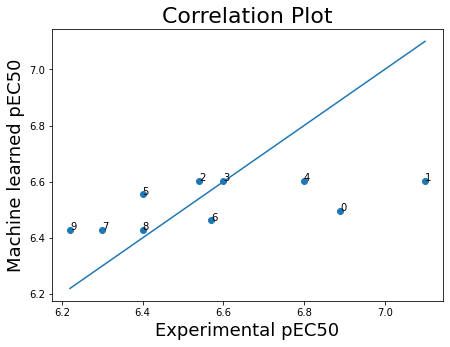

In [31]:

# Generate a correlation plot between the machine learning predicted pEC50 values (y_pred) and experimental pEC50 (y_test)

from matplotlib import pyplot as plt

#plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_test, y_pred)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], '-')
for (i, j) in enumerate(list(range(len(y_test)))):
    ax.annotate(j, (y_test[i], y_pred[i]))
plt.xlabel("Experimental pEC50", fontsize=18)
plt.ylabel("Machine learned pEC50", fontsize=18)
ax.set_title('Correlation Plot', fontsize=22)
plt.show()

# NB adjust random_state value during model building for a better fit


In [32]:
import sklearn.metrics as sklm
import scipy.stats as ss
import math
# Evaluate model

y_true = y_test 
y_predicted = y_pred

# Compute R^2
r2 = sklm.r2_score(y_true, y_predicted)
print("R^2 value                 = " + str(r2))

# Print stats
print("Mean Square Error         = " + str(sklm.mean_squared_error(y_true, y_predicted)))
print("Root Mean Square Error    = " + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
print("Mean Absolute Error       = " + str(sklm.mean_absolute_error(y_true, y_predicted)))
print("Median Absolute Error     = " + str(sklm.median_absolute_error(y_true, y_predicted)))

# ========================

# Based on the correlation plot and the stats below, the model did not do very well
# The descriptors are not strongly correlated to the response
# Will require better parameterisation


R^2 value                 = 0.21079111575040022
Mean Square Error         = 0.05443647200000035
Root Mean Square Error    = 0.2333162488983576
Mean Absolute Error       = 0.17867999999999773
Median Absolute Error     = 0.14224999999999488


In [33]:

# =================================================== #
# Use the ML model to predict pEC50 for new compounds 
# =================================================== #


In [34]:
# Read in new set of cpds 

df_new = pd.read_csv("./Hsp70_TestCpds.csv")
df_new

,Compound,SMILES
0,CHEMBL541416,C1C[N+]2=C3C4=C1C=NC4=C(C5=C3C67CC(N5)SC6=CC(=...
1,CHEMBL464379,C1CN=C2C3=C1C=NC3=C(C4=C2C56CC(N4)SC5=CC(=O)C=...
2,CHEMBL512945,COC1CC2C3(CCN2CC4=CC5=C(C=C43)OCO5)C=C1
3,CHEMBL522637,CC1CCC2C(=CCC(C(O2)(C)C)O)C1(C)CCC3(C(CCC4C35C...
4,CHEMBL523911,CC=C1CC(=C)C(C(=O)OCC2=CCN3C2C(CC3)OC1=O)(C)O
5,CHEMBL98683,C1CC(=O)OCC=CC2=CC=C(C=C2)OC3=C(C=CC1=C3)O


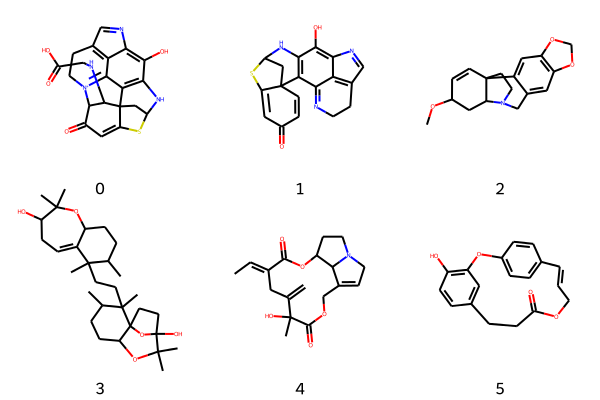

In [35]:

# Our new data set looks like

df_new['smi_Mols'] = [Chem.MolFromSmiles(x) for x in df_new['SMILES']]

rdDepictor.SetPreferCoordGen(True)
Draw.MolsToGridImage(df_new['smi_Mols'], molsPerRow=3, legends=[str(i) for i in list(range(len(df_new['smi_Mols'])))])


In [36]:

# Calculate features

x_test_new = Mordred_descriptors(df_new['SMILES'])


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


In [37]:

# Obtain the statistically significant features for model building

curated_new = x_test_new[curated_features.columns]

curated_new.head()

,nI,MWC06,MWC04,Xch-7d,Xpc-5dv,MWC08,MWC05,MWC02,MWC03,AATSC5are
0,0,9.195531,7.193686,1.470670,8.173849,11.212401,8.187855,5.231109,6.196444,-0.012343
1,0,8.908018,6.955593,1.347688,5.711280,10.869501,7.925519,5.030438,5.978886,-0.008788
2,0,8.653645,6.741701,1.051410,4.468669,10.577274,7.693026,4.859812,5.789960,0.018125
3,0,9.199583,7.267525,1.167164,12.923562,11.141876,8.225503,5.361292,6.293419,-0.001090
4,0,8.453827,6.655440,0.594116,2.965988,10.257484,7.550135,4.875197,5.752573,-0.019654


In [38]:

# Use the previously generated models to predict pEC50 values for new molecules

# Features (transform into numpy arrays)
X_new = np.array(curated_new)


In [39]:

# Predict pEC50 for the new set of compounds

pred_new = rfmod.predict(X_new)


In [40]:

# print pEC50 values

print(np.around(pred_new,2))  #y_predicted


[6.63 6.67 4.9  6.57 5.4  5.06]


In [41]:

# Therefore the predicted pEC50 values for our new dataset are:

df_new['pEC50'] = pred_new

df_new[['Compound', 'SMILES', 'pEC50']]


,Compound,SMILES,pEC50
0,CHEMBL541416,C1C[N+]2=C3C4=C1C=NC4=C(C5=C3C67CC(N5)SC6=CC(=...,6.630100
1,CHEMBL464379,C1CN=C2C3=C1C=NC3=C(C4=C2C56CC(N4)SC5=CC(=O)C=...,6.668900
2,CHEMBL512945,COC1CC2C3(CCN2CC4=CC5=C(C=C43)OCO5)C=C1,4.898253
3,CHEMBL522637,CC1CCC2C(=CCC(C(O2)(C)C)O)C1(C)CCC3(C(CCC4C35C...,6.574600
4,CHEMBL523911,CC=C1CC(=C)C(C(=O)OCC2=CCN3C2C(CC3)OC1=O)(C)O,5.401828
5,CHEMBL98683,C1CC(=O)OCC=CC2=CC=C(C=C2)OC3=C(C=CC1=C3)O,5.059757


In [42]:
# == REFERENCE == #

#1. Sabbadini, R. et al. Pharmaceuticals. 14, 1296 (2021).
#2. Hao Shao. et al. ACS jmedchem. 61 (14), 6163-6177 (2018) 
#3. Xiaokai Li. et al. ACS Med. Chem. Lett. 4 (11), 1042-1047 (2013)
#4. Moriwaki, H. et al. BMC J Cheminform. 10, 4 (2018)